# Detect Anomalies Using Density Based Clustering


## Clustering-Based Anomaly Detection

- Assumption: Data points that are similar tend to belong to similar groups or clusters, as determined by their distance from local centroids. Normal data points occur around a dense neighborhood and abnormalities are far away.

- Using density based clustering, like DBSCAN, we can design the model such that the data points that do not fall into a cluster are the anomalies.


In [1]:
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
# DBSCAN import
from sklearn.cluster import DBSCAN
# Scaler import
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline


In [2]:
# Import .csv file and convert it to a DataFrame object
df = pd.read_table("curriculum-access.txt", sep = '\s', header = None, 
                   names = ['date', 'time', 'page', 'id', 'cohort', 'ip'])


In [3]:
df.head(2)

,date,time,page,id,cohort,ip
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61


Explore

In [4]:
# lets do a little aggregation based on the student id's in the data set
id_counts = df.groupby('id')['date','cohort','page'].nunique()

In [5]:
id_counts

,date,cohort,page
id,,,
1,685,2,1018
2,83,1,151
3,107,1,169
4,54,1,143
5,82,1,197
...,...,...,...
1078,7,1,12
1079,7,1,10
1080,7,1,9


In [6]:
# initial questions:
# id #1 is likely a curriculum developer or someone involved on the Codeup side.
# We have some instances near the bottom of a single or < week number of page/day access
# what different values can we associate with mulitple cohort assignments?

In [7]:
cohort_counts = df.groupby('cohort')['page', 'id','date'].nunique()

In [8]:
cohort_counts

,page,id,date
cohort,,,
1.0,428,48,330
2.0,44,3,14
4.0,4,1,1
5.0,1,1,1
6.0,45,2,12
7.0,191,6,54
8.0,278,5,162
9.0,4,1,1
11.0,95,5,18


In [9]:
df['date'] = pd.to_datetime(df.date)

In [10]:
df.head()

,date,time,page,id,cohort,ip
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [11]:
first_access = df.groupby('id')['date'].min()

In [12]:
first_access

id
1      2018-01-26
2      2018-01-26
3      2018-01-26
4      2018-01-26
5      2018-01-26
          ...    
1078   2021-07-04
1079   2021-07-06
1080   2021-07-06
1081   2021-07-12
1082   2021-07-13
Name: date, Length: 1082, dtype: datetime64[ns]

In [13]:
id_by_first_access_date = pd.DataFrame({'first_access_date': first_access}\
                                      ).reset_index().groupby('first_access_date').count()

In [14]:
id_by_first_access_date

,id
first_access_date,
2018-01-26,50
2018-01-27,2
2018-01-28,2
2018-01-29,12
2018-01-30,7
...,...
2021-06-28,23
2021-07-04,2
2021-07-06,2


In [15]:
id_by_first_access_date.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 273 entries, 2018-01-26 to 2021-07-13
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      273 non-null    int64
dtypes: int64(1)
memory usage: 4.3 KB


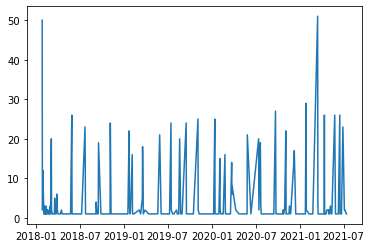

In [16]:
plt.plot(id_by_first_access_date)
plt.show()

In [17]:
# people that were in more than one cohort?

In [18]:
id_counts[id_counts.cohort > 1]

,date,cohort,page
id,,,
1,685,2,1018
11,896,2,883
25,114,2,154
37,43,2,156
40,102,2,120
41,221,2,186
51,99,2,239
53,815,2,443
64,765,3,453


In [19]:
id_counts[id_counts.cohort > 1].shape

(44, 3)

Could someone be stealing the content of our curriculum for their benefit beyond personal education? If so, we would probably see them accessing a large number of unique pages. I would imagine they wouldn't spend much time on each page, maybe taking screen shots, copy/paste or downloading the content. Let's take a look. 

Aggregate and compute 2 features...number of unique pages and total page views. 

In [20]:
page_views = df.groupby(['id'])['page'].agg(['count', 'nunique'])

In [21]:
page_views

,count,nunique
id,,
1,8190,1018
2,1541,151
3,1562,169
4,692,143
5,1701,197
...,...,...
1078,44,12
1079,60,10
1080,27,9


In [22]:
page_views[(page_views['count'] < 200) & (page_views['count'] > 190)]

,count,nunique
id,,
16,199,57
22,199,68
42,199,77
129,199,38
257,194,81
676,192,50
932,194,63
946,191,33
994,194,56


Scale each attribute linearly. 

In [23]:
# create the scaler
scaler = MinMaxScaler().fit(page_views)

# use the scaler
page_views_scaled_array = scaler.transform(page_views)

In [24]:
page_views_scaled_array[0:5]

array([[0.41799806, 1.        ],
       [0.07860752, 0.14749263],
       [0.07967944, 0.16519174],
       [0.0352713 , 0.13962635],
       [0.08677454, 0.1927237 ]])

Construct a DBSCAN object that requires a minimum of 20 data points in a neighborhood of radius 0.1 to be considered a core point.

In [25]:
dbsc = DBSCAN(eps=0.1, min_samples=20)
dbsc.fit(page_views_scaled_array)

DBSCAN(eps=0.1, min_samples=20)

In [26]:
scaled_columns = ['scaled_' + col for col in page_views.columns]

In [27]:
page_views_scaled_array.shape

(1082, 2)

In [28]:
scaled_df = pd.DataFrame(page_views_scaled_array, columns = scaled_columns, index=page_views.index)

In [29]:
scaled_df.head(2)

,scaled_count,scaled_nunique
id,,
1,0.417998,1.000000
2,0.078608,0.147493


In [30]:
# Merge the scaled and non-scaled values into one dataframe
# page_views = pd.concat([page_views, scaled_df], axis=1)

In [31]:
# let's apply the dbscan labels

In [32]:
page_views.shape

(1082, 2)

In [33]:
scaled_df.shape

(1082, 2)

In [34]:
page_views.head()

,count,nunique
id,,
1,8190,1018
2,1541,151
3,1562,169
4,692,143
5,1701,197


In [35]:
page_views = page_views.merge(scaled_df, left_index=True, right_index=True)

In [37]:
page_views.shape

(1082, 4)

In [38]:
# grab our labels from our cluster model
labels = dbsc.labels_

In [39]:
labels.size

1082

In [42]:
page_views['labels'] = labels

In [43]:
# Let's look at the descriptive stats for the entire population, the inliers, then the outliers/anomalies
print("Population")
print(page_views.describe())
print("-------------")
print("Inliers")
print(page_views[page_views.labels==0].describe())
print("-------------")
print("Outliers")
print(page_views[page_views.labels==-1].describe())

Population
              count      nunique  scaled_count  scaled_nunique       labels
count   1082.000000  1082.000000   1082.000000     1082.000000  1082.000000
mean     941.597967   120.389094      0.048012        0.117393    -0.007394
std     1238.102570    80.299527      0.063198        0.078957     0.085708
min        1.000000     1.000000      0.000000        0.000000    -1.000000
25%      199.000000    55.250000      0.010107        0.053343     0.000000
50%      720.500000   140.000000      0.036726        0.136676     0.000000
75%     1317.750000   165.000000      0.067212        0.161259     0.000000
max    19592.000000  1018.000000      1.000000        1.000000     0.000000
-------------
Inliers
             count      nunique  scaled_count  scaled_nunique  labels
count  1074.000000  1074.000000   1074.000000     1074.000000  1074.0
mean    867.455307   117.306331      0.044227        0.114362     0.0
std     800.249247    68.335681      0.040848        0.067193     0.0
min

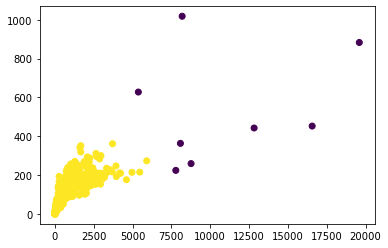

In [44]:
plt.scatter(page_views['count'], page_views['nunique'], c=page_views.labels)
plt.show()

## Experiment with the DBSCAN properties
- Read up on the epsilon and min_samples arguments into DBSCAN at https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
- Experiment with altering the epsilon values (the `eps` argument holding the threshhold parameter). Run the models and visualize the results. What has changed? Why do you think that is?
- Double the `min_samples` parameter. Run your model and visualize the results. Consider what changed and why.

# Exercise

**file name:** clustering_anomaly_detection.py or clustering_anomaly_detection.ipynb


### Clustering - DBSCAN

Ideas: 

Use DBSCAN to detect anomalies in curriculumn access. 

Use DBSCAN to detect anomalies in other products from the customers dataset. 

Use DBSCAN to detect anomalies in number of bedrooms and finished square feet of property for the filtered dataset you used in the clustering project (single unit properties with a logerror).
